# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [69]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

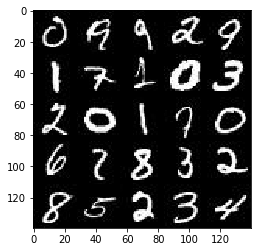

In [70]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

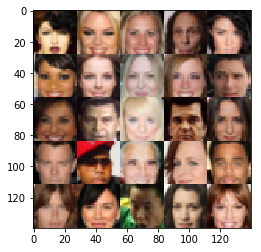

In [71]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [72]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [73]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [103]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#                               activation=None)
        
        relu1 = tf.maximum(alpha * x1, x1)
        #16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        x3 = tf.nn.dropout(relu3, keep_prob=0.9)
        #4x4x256

        #Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):

        #First fully connected layer
        y1 = tf.layers.dense(z, 7*7*256)

        #conv > batch_norm > leaky relu

        #Reshape to start the convolutional stack
        y1 = tf.reshape(y1, (-1, 7, 7, 256)) 
        y1 = tf.layers.batch_normalization(y1, training=is_train)
        y1 = tf.maximum(alpha * y1, y1)
        #4x4x512

        #2nd convolution
        y2 = tf.layers.conv2d_transpose(y1, 256, 1, strides=1, padding='same')
        y2 = tf.layers.batch_normalization(y2, training=is_train)
        y2 = tf.maximum(alpha * y2, y2)
#         y2 = tf.nn.dropout(y2, keep_prob=0.9)
        #4x4x256
        
        y3 = tf.layers.conv2d_transpose(y2, 128, 4, strides=2, padding='same')
        y3 = tf.layers.batch_normalization(y3, training=is_train)
        y3 = tf.maximum(alpha * y3, y3)
        #8x8x128
        
        y4 = tf.layers.conv2d_transpose(y3, 128, 1, strides=1, padding='same')
        y4 = tf.layers.batch_normalization(y4, training=is_train)
        y4 = tf.maximum(alpha * y4, y4)
        
        y5 = tf.layers.conv2d_transpose(y4, 128, 4, strides=2, padding='same')
        y5 = tf.layers.batch_normalization(y5, training=is_train)
        y5 = tf.maximum(alpha * y5, y5)
        
        y5 = tf.nn.dropout(y5, keep_prob=0.9)
        
        
        
        
        logits = tf.layers.conv2d_transpose(y5, out_channel_dim, 1, strides=1, padding='same')
        #16x16x
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [104]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)* (1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [90]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
       

        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [91]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [92]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    saver = tf.train.Saver()
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_d_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_g_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    # Save losses to view after training
                    losses.append((train_d_loss, train_g_loss))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        
        saver.save(sess, './generator.ckpt')
        
        return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3694... Generator Loss: 0.2512
Epoch 1/2... Discriminator Loss: 2.6626... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 2.3013... Generator Loss: 0.3415
Epoch 1/2... Discriminator Loss: 2.1625... Generator Loss: 0.2320
Epoch 1/2... Discriminator Loss: 1.9799... Generator Loss: 0.4944
Epoch 1/2... Discriminator Loss: 1.7617... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.7719... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.8939... Generator Loss: 0.3036


Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.5882... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.5705... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.5444... Generator Loss: 0.5064
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.4238
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 0.4887


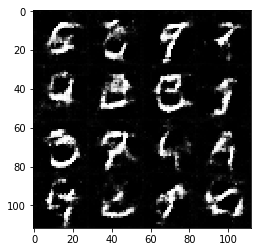

Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.5338... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 1.6046... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.5086... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.5620


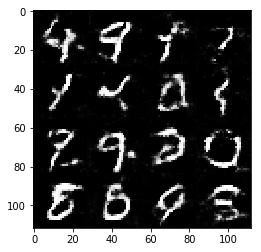

Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.9711
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.6955... Generator Loss: 1.4539
Epoch 1/2... Discriminator Loss: 1.8926... Generator Loss: 0.3369
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.4681
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.9743


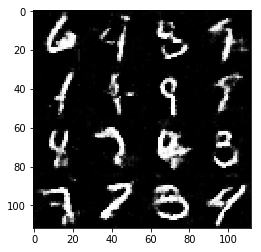

Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.6252... Generator Loss: 0.4037
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.4382
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.6277


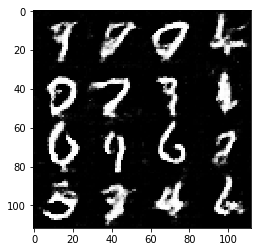

Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.4754... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.4641


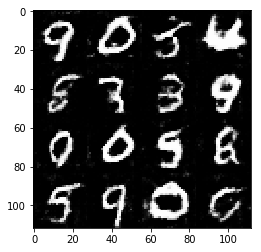

Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.5029
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.6548... Generator Loss: 0.4129
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.4787
Epoch 1/2... Discriminator Loss: 1.7737... Generator Loss: 0.3266
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.7851


Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.8012... Generator Loss: 0.3008
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.6143


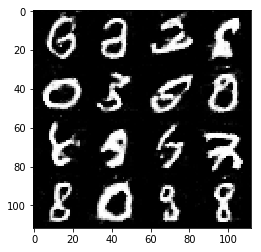

Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.6423
Epoch 1/2... Discriminator Loss: 1.7820... Generator Loss: 0.3298
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.4635... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.6505


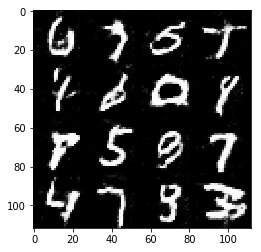

Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.5001
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.6327... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 1.4490... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.5382
Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.6714


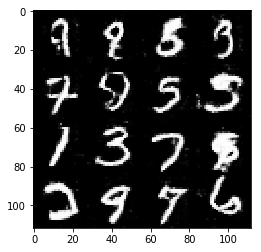

Epoch 2/2... Discriminator Loss: 1.5373... Generator Loss: 0.4645
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.6155
Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 1.1355
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.8694


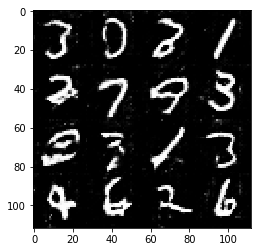

Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 0.4331
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.5914... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.5510
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 1.5658... Generator Loss: 0.5383


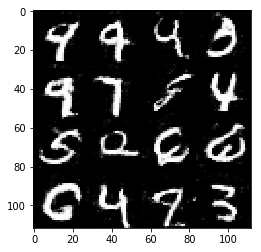

Epoch 2/2... Discriminator Loss: 1.5843... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.5679... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.5302
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.5602... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.6092


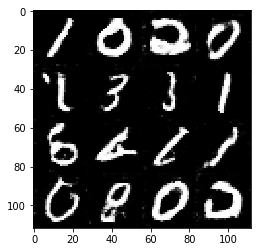

Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.5706... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 1.5191... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 0.5930


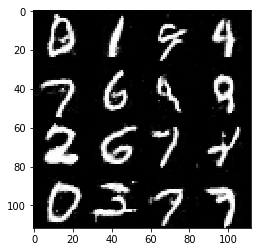

Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 1.4536... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.6654


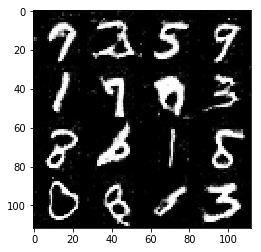

Epoch 2/2... Discriminator Loss: 1.5280... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.7561


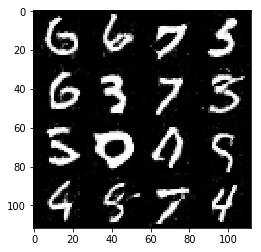

Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.4587... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 1.4795... Generator Loss: 0.5343
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.6383
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.6876


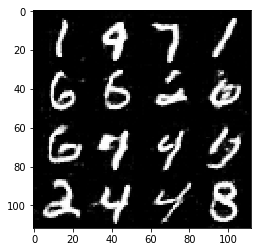

Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.7374... Generator Loss: 0.3819
Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.6217


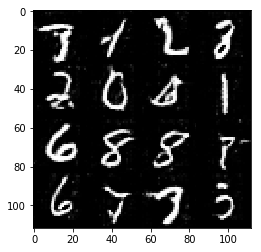

Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.5146... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.6445


In [112]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.6122... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.8166... Generator Loss: 0.3667
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 2.0598
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.5650
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.3820
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 2.1321
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.0459


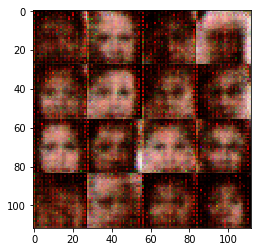

Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.7731... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.9185
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 1.5302
Epoch 1/2... Discriminator Loss: 1.7784... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.6674


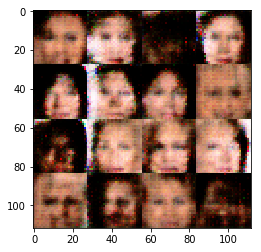

Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 1.2269


Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 1.5383... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.6677


Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.5831... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.5260
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.5280... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 1.2820
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.6550


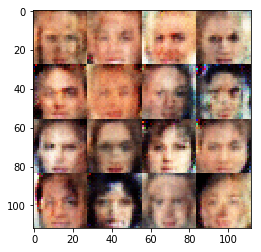

Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.8195
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 1.0311
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.6552


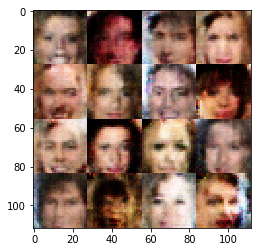

Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 1.4321... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.8598


Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.8282
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.5396... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.5338... Generator Loss: 0.8016


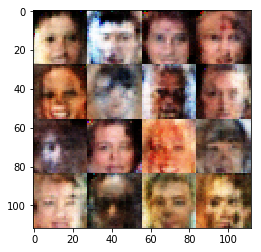

Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.5496... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.7850


Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.8427


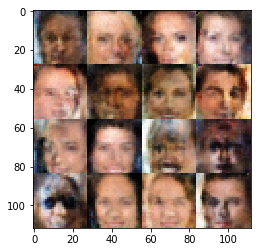

Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 1.5277... Generator Loss: 0.6790


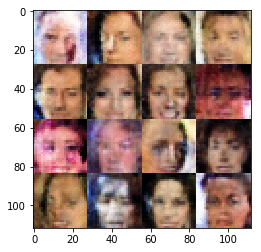

Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.7262
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.7247


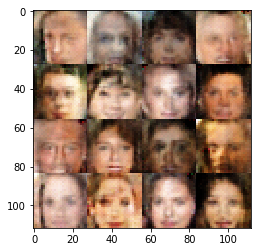

Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.5628


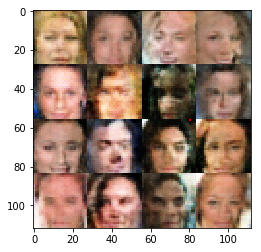

Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 1.5245... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.8000


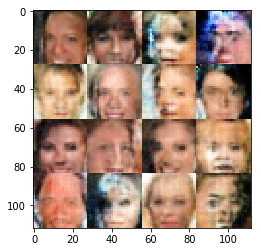

Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.5601... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.6671


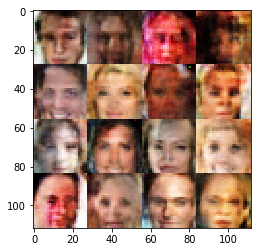

Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.6062... Generator Loss: 0.4989
Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.7371


Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.8809
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.6432


Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.6042... Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.7020


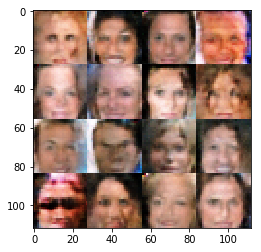

Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.6995


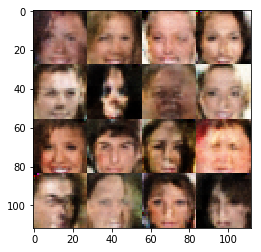

Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.6505


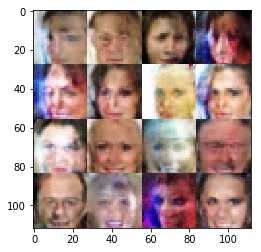

Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.6364


Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.4861... Generator Loss: 0.6098


Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 1.5841... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.7822


Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6520


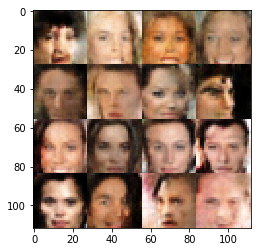

Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.5820
Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.7334


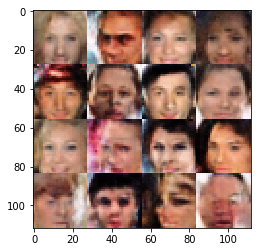

Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.6635


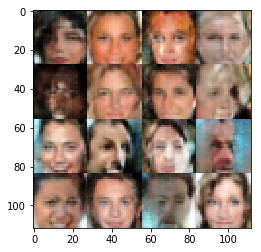

Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.5680


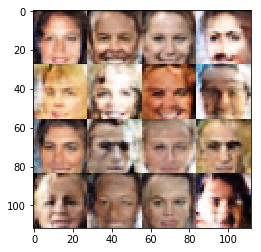

Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.5280... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7466


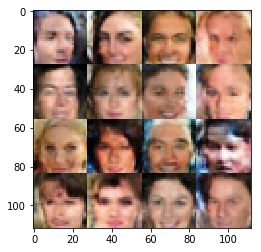

Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.7398


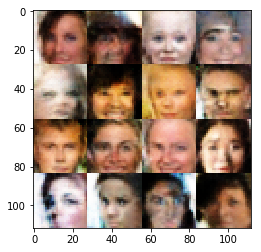

Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.5577... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.6803


Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.5735
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.7244


Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.9190... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.9018
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.5470... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.6936


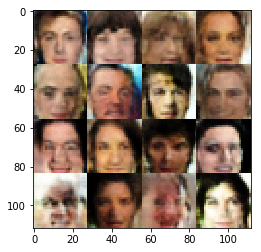

Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.5795
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.7141
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.6979


Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.6286
Epoch 2/2... Discriminator Loss: 1.4781... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.6497


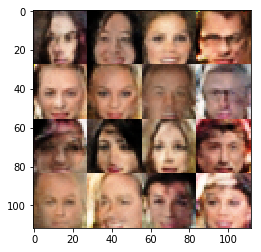

Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7858


Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7485
Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.4153... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.4543... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.8699


Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.5466... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.4337... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7104


Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.4697... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.4930... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.9773... Generator Loss: 0.9967
Epoch 2/2... Discriminator Loss: 1.5481... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.5169... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.7075


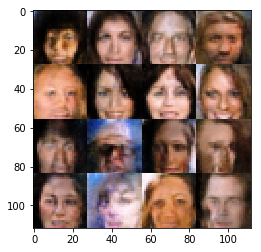

Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.6682
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.7393


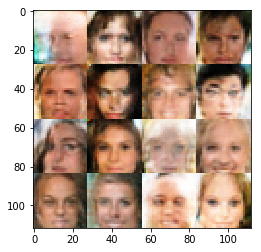

Epoch 2/2... Discriminator Loss: 1.4817... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.4008... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.7433


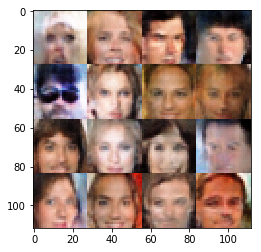

Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.4904... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 1.4707... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.5168... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.7292


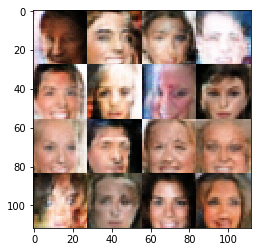

Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 1.5329... Generator Loss: 0.5367
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.7805


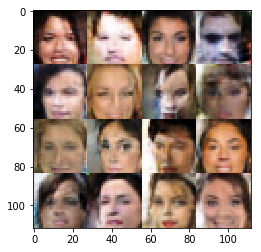

Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.8328


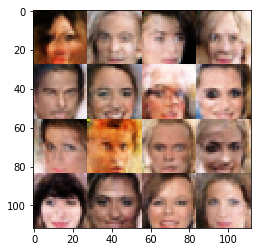

Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 1.5811... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.6064
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.9045
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.4434... Generator Loss: 0.5876
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.6742


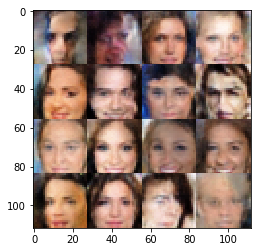

Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 1.4183... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.4970... Generator Loss: 0.6124
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 1.0060


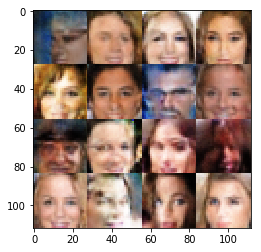

Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 1.3711... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.7572


Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.4067... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.5355... Generator Loss: 0.5076
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.6884


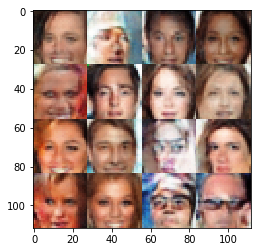

Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.9700
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.6251... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.6209


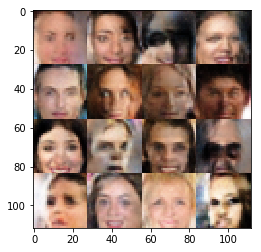

Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.5036... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.8116


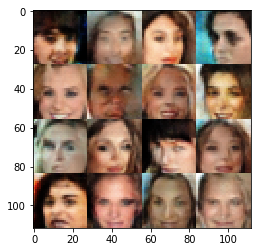

Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 2.0356... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 1.6556... Generator Loss: 0.4341


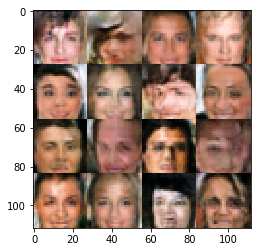

Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.6276... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.5049... Generator Loss: 0.4695
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.6899


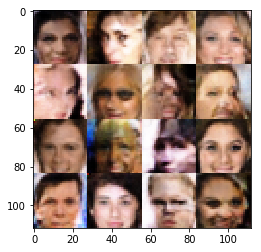

Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 0.7783


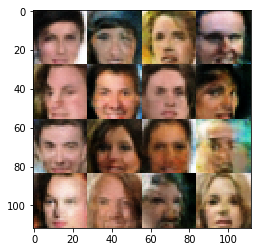

Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 2.3059... Generator Loss: 1.9038
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.0756
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.6181


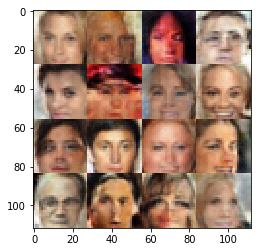

Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 1.0303
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.1759... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 2.1143... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 1.3331
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 1.7571


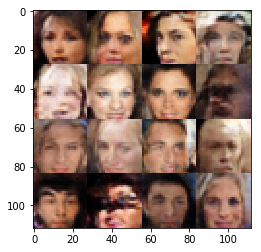

Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.5310
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.7102


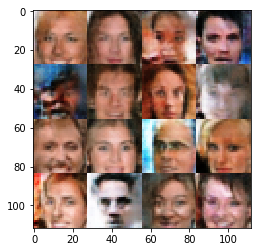

Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.5519
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.5417
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 1.0311


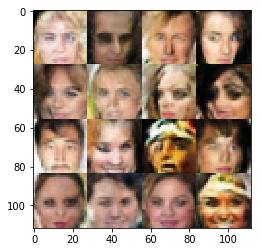

Epoch 2/2... Discriminator Loss: 1.7384... Generator Loss: 0.3067
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.7693... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.5047


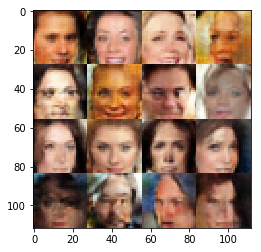

Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 1.7287... Generator Loss: 1.6679
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.4901... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.7128


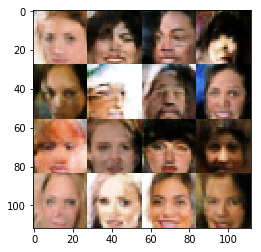

Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.2876
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.4374
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.0696
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 1.2067
Epoch 2/2... Discriminator Loss: 1.3175... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.8706


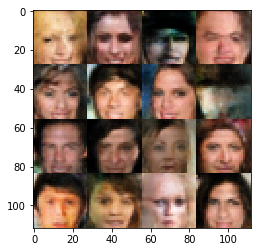

Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 1.2439
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 0.6069
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 1.3400
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.5560
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.5805
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.6134


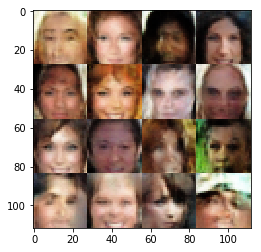

Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 0.9192... Generator Loss: 1.3270
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 1.9552
Epoch 2/2... Discriminator Loss: 1.9963... Generator Loss: 0.2801
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.5891... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 1.3487


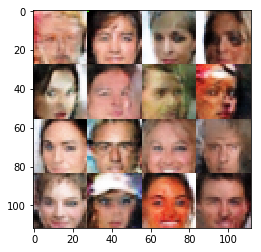

Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.2925
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.2948
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 1.9253


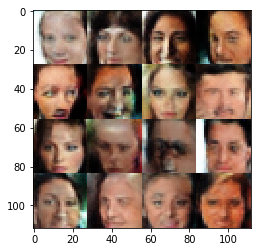

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.3822


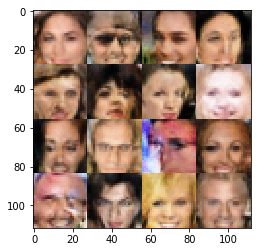

Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.6117... Generator Loss: 0.7379


In [113]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.